In [1]:
import ftl.dw_call as dw
import boto3
from copy import deepcopy
from pathlib import Path
import os
import shutil
import glob

import pandas as pd
from pandas.errors import ParserError
import numpy as np
from datetime import datetime
from fiona.collection import DriverError
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import geopandas as gpd
from osgeo import gdal
from shapely.ops import unary_union
from shapely.geometry import Polygon
from io import BytesIO
import rasterio
import rasterio as rio
import rasterio.plot
from rasterio.transform import Affine
from rasterstats import zonal_stats
import pyproj

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [9]:
cnt_501=pd.read_csv('501_treatment.csv')
cnt_502=pd.read_csv('502_treatment.csv')

In [10]:
combine=pd.concat([cnt_501,cnt_502], ignore_index=True)
count_df=combine.groupby(['treatment'])['Identify'].sum().reset_index()
count_df['Percentage'] = (count_df['Identify'] / count_df['Identify'].sum()) * 100

In [11]:
count_df

,treatment,Identify,Percentage
0,1,0,0.000000
1,2,7,9.459459
2,3,17,22.972973
3,4,11,14.864865
4,5,7,9.459459
5,6,8,10.810811
6,7,5,6.756757
7,8,3,4.054054
8,9,8,10.810811
9,10,8,10.810811


In [18]:
# type_meanings = {'1': 'NTC & N:100%', '2': '2022-PVX & N:100%-50 LB', '3': 'NTC & N:100%-50 LB', 
#                  '4': '2022-PVX2 & N:100%-50 LB', '5': '2022-PBX3WAY & N:100%-50 LB','6': '2022-PBX5WAY & N:100%-50 LB', 
#                  '7': '2022-PV40ST & N:100%-40 LB',
#                 '8': '2022-PV40ST & N:100%','9': 'NTC & N:0 LB', '10': '2022-PV40ST & N:0 LB'}
count_df['treatment'] = count_df['treatment'].astype(str)

list1=['1','3','9']
control_treats=count_df[count_df.treatment.isin(list1)]

list2=['2','4','5','6','7','8','10']
experiment_treats=count_df[count_df.treatment.isin(list2)]

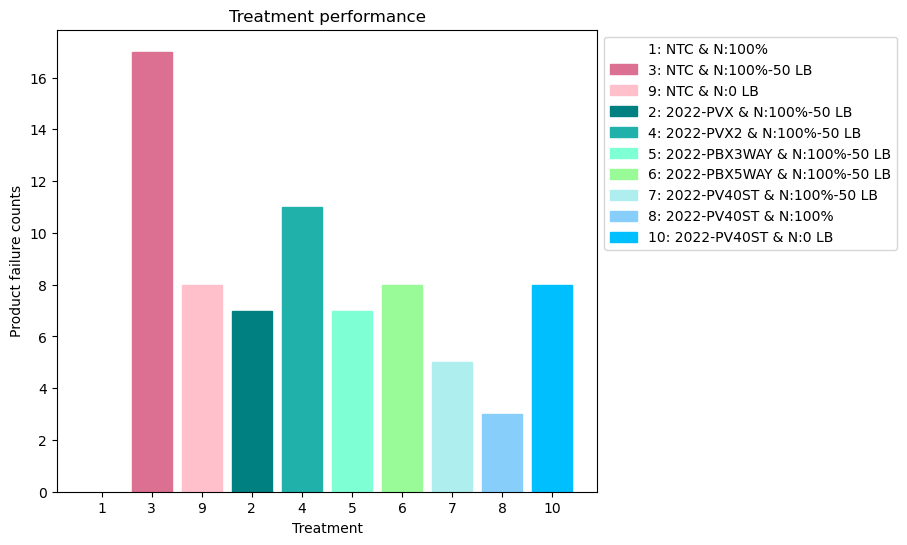

In [32]:
# sns.barplot(x='treatment', y='Percentage', data=control_treats)
type_meanings1 = {'1': 'NTC & N:100%',  '3': 'NTC & N:100%-50 LB', '9': 'NTC & N:0 LB',
                 '2': '2022-PVX & N:100%-50 LB', '4': '2022-PVX2 & N:100%-50 LB', '5': '2022-PBX3WAY & N:100%-50 LB',
                  '6': '2022-PBX5WAY & N:100%-50 LB', '7': '2022-PV40ST & N:100%-50 LB',
                '8': '2022-PV40ST & N:100%','10': '2022-PV40ST & N:0 LB'
                 }

colors = ['white', 'palevioletred', 'pink', 'teal','lightseagreen','aquamarine','palegreen','paleturquoise','lightskyblue','deepskyblue']
colors1 = ['white', 'palevioletred', 'pink']
colors2 = ['teal','lightseagreen','aquamarine','palegreen','paleturquoise','lightskyblue','deepskyblue']

plt.figure(figsize=(8, 6))
bars1 = plt.bar(control_treats['treatment'], control_treats['Identify'])

for i, bar in enumerate(bars1):
    bar.set_color(colors1[i])

bars2 = plt.bar(experiment_treats['treatment'], experiment_treats['Identify'])

for i, bar in enumerate(bars2):
    bar.set_color(colors2[i])
    
    
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = [f"{type_}: {meaning}" for type_, meaning in type_meanings1.items()]
plt.legend(legend_handles, legend_labels,loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('Treatment')
plt.ylabel('Product failure counts')
plt.title('Treatment performance')
plt.subplots_adjust(right=0.8)
plt.show()

# Modeling

In [43]:
model_names=[]
###for training
accuracys1=[]
precisions1=[]
recalls1=[]
f1s1=[]
roc_aucs1=[]
pr_aucs1=[]
###for testing
accuracys2=[]
precisions2=[]
recalls2=[]
f1s2=[]
roc_aucs2=[]
pr_aucs2=[]

###for validation
pr_aucs3=[]

In [44]:
def add_print_metrics1(model_idx, y, y_pred, y_proba):
    accuracys1.append(accuracy_score(y, y_pred))
    precisions1.append(precision_score(y, y_pred))
    recalls1.append(recall_score(y, y_pred))
    f1s1.append(f1_score(y, y_pred))
    roc_aucs1.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs1.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")
    
def add_print_metrics2(model_idx, y, y_pred, y_proba):
    accuracys2.append(accuracy_score(y, y_pred))
    precisions2.append(precision_score(y, y_pred))
    recalls2.append(recall_score(y, y_pred))
    f1s2.append(f1_score(y, y_pred))
    roc_aucs2.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs2.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")

In [45]:
# as this is an imbalanced dataset, we use PR-AUC as the evaluation metris in training
scorer = make_scorer(average_precision_score, greater_is_better = True)

In [46]:
features = ['latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d','1',
       '2', '3', '4', '5', '6','7','8','9','10','Identify']

target = 'Identify'
features.remove(target)

## StageV3

In [47]:
df_v3_get_501=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\df_v3_get_incase.csv')
df_v3_get_502=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\Protocol_502\df_v3_get_incase_502.csv')

In [48]:
df_model_v3_501=df_v3_get_501[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

df_model_v3_502=df_v3_get_502[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv',
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '7', '8', '9', '10', '11','Identify']]

In [49]:
df_model_v3_501=df_model_v3_501[df_model_v3_501.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v3_501['norm_ndvi_mean'] = scaler.fit_transform(df_model_v3_501[['ndvi_mean']])
df_model_v3_501['norm_ndvi_std'] = scaler.fit_transform(df_model_v3_501[['ndvi_std']].values)
df_model_v3_501['norm_ndre_mean'] = scaler.fit_transform(df_model_v3_501[['ndre_mean']].values)
df_model_v3_501['norm_ndre_std'] = scaler.fit_transform(df_model_v3_501[['ndre_std']].values)

df_model_v3_501['ndvi_mean__diff'] = df_model_v3_501.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v3_501['ndvi_std_diff'] = df_model_v3_501.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v3_501['ndre_mean_diff'] = df_model_v3_501.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v3_501['ndre_std_diff'] = df_model_v3_501.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [50]:
df_model_v3_502=df_model_v3_502[df_model_v3_502.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v3_502['norm_ndvi_mean'] = scaler.fit_transform(df_model_v3_502[['ndvi_mean']])
df_model_v3_502['norm_ndvi_std'] = scaler.fit_transform(df_model_v3_502[['ndvi_std']].values)
df_model_v3_502['norm_ndre_mean'] = scaler.fit_transform(df_model_v3_502[['ndre_mean']].values)
df_model_v3_502['norm_ndre_std'] = scaler.fit_transform(df_model_v3_502[['ndre_std']].values)

df_model_v3_502['ndvi_mean__diff'] = df_model_v3_502.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v3_502['ndvi_std_diff'] = df_model_v3_502.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v3_502['ndre_mean_diff'] = df_model_v3_502.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v3_502['ndre_std_diff'] = df_model_v3_502.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [51]:
df_model_v3_501.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,6,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US501-IA01-5FELDM,41.864641,266.375284,0.283106,0.08342,0.194885,0.058098,-22.523012,-22.375841,2.163079,...,0.0,0,0.3204,0.23284,0.18826,0.106166,0.0,0.0,0.0,0.0


In [52]:
df_model_v3_502.columns

Index(['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '7', '8',
       '9', '10', '11', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff'],
      dtype='object')

In [53]:
df_model_v3_502.columns=['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '3', '7',
       '8', '9', '10', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff']

df_model_v3_502.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,10,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US502-IA01-5HEIMS,42.624221,268.519802,0.383388,0.010286,0.30543,0.012132,-20.057127,-20.063561,1.805224,...,0.0,0,0.423537,0.203573,0.364664,0.37162,0.0,0.0,0.0,0.0


In [54]:
df_model_v3_501=df_model_v3_501.dropna()
df_model_v3_502=df_model_v3_502.dropna()

print("501 shape:",df_model_v3_501.shape)
print("502 shape:",df_model_v3_502.shape)

501 shape: (66, 40)
502 shape: (44, 40)


In [55]:
df_model_v3=pd.concat([df_model_v3_501,df_model_v3_502], ignore_index=True)
df_model_v3.fillna(0, inplace=True)

StageV3 501 Successfull application 41
StageV3 501 Failure 25
StageV3 502 Successfull application 19
StageV3 502 Failure 25
StageV3 All Successfull application 60
StageV3 All Failure 50


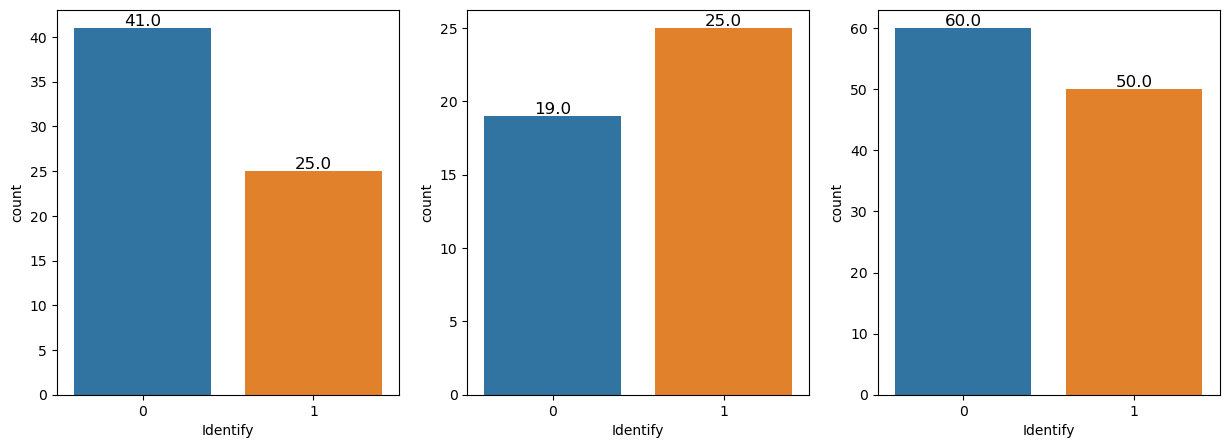

In [56]:
print("StageV3 501 Successfull application",df_model_v3_501[df_model_v3_501.Identify==0].Identify.count())
print("StageV3 501 Failure",df_model_v3_501[df_model_v3_501.Identify==1].Identify.count())

print("StageV3 502 Successfull application",df_model_v3_502[df_model_v3_502.Identify==0].Identify.count())
print("StageV3 502 Failure",df_model_v3_502[df_model_v3_502.Identify==1].Identify.count())

print("StageV3 All Successfull application",df_model_v3[df_model_v3.Identify==0].Identify.count())
print("StageV3 All Failure",df_model_v3[df_model_v3.Identify==1].Identify.count())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ax1=sns.countplot(data=df_model_v3_501, x='Identify')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
#
plt.subplot(1, 3, 2)
ax2=sns.countplot(data=df_model_v3_502, x='Identify')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.subplot(1, 3, 3)
ax3=sns.countplot(data=df_model_v3, x='Identify')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Train in 501 Test 501

In [57]:
part1=df_model_v3.iloc[0:66,:]

In [58]:
train_raw1, test_raw1 = train_test_split(part1,test_size=0.2, random_state=0)

In [59]:
X_train1 = train_raw1[features]
y_train1 = train_raw1[target]

X_test1 = test_raw1[features]
y_test1 = test_raw1[target]

In [60]:
model_names.append('LR_v3_501train_501test')

In [61]:
#### with amp
steps1 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model1 = Pipeline(steps1)

params1 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun1 = GridSearchCV(estimator = model1, param_grid = params1, scoring = scorer, cv = 5,error_score="raise")

model_tun1 = model_tun1.fit(X_train1, y_train1)

print('The best parameters finally chose are',model_tun1.best_params_)
print('The ROC_AUC score from these parameters is',model_tun1.best_score_)

pr_aucs3.append(model_tun1.best_score_)

y_train_pred_lr1=model_tun1.best_estimator_.predict(X_train1)
y_train_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_train1)

y_test_pred_lr1=model_tun1.best_estimator_.predict(X_test1)
y_test_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_test1)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train1,y_train_pred_lr1,y_train_proba_lr1)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test1,y_test_pred_lr1,y_test_proba_lr1)

The best parameters finally chose are {'lr__C': 0.1, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.6721969696969696
-------------------------Train dataset Result------------------------------
LR_v3_501train_501test Accuracy score is 0.8846153846153846
LR_v3_501train_501test Precision score is 0.7619047619047619
LR_v3_501train_501test Recall score is 0.9411764705882353
LR_v3_501train_501test F1 score is 0.8421052631578947
LR_v3_501train_501test ROC-AUC score is 0.9815126050420169
LR_v3_501train_501test PR-AUC score is 0.9679458949355144
-------------------------Test dataset Result------------------------------
LR_v3_501train_501test Accuracy score is 0.5714285714285714
LR_v3_501train_501test Precision score is 0.75
LR_v3_501train_501test Recall score is 0.375
LR_v3_501train_501test F1 score is 0.5
LR_v3_501train_501test ROC-AUC score is 0.625
LR_v3_501train_501test PR-AUC score is 0.7707656926406926


Confusion Matrix:
[[5 1]
 [5 3]]


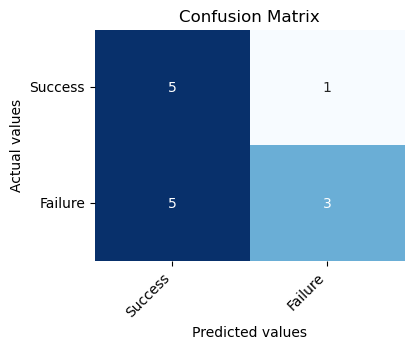

In [62]:
cm1 = confusion_matrix(y_test1, y_test_pred_lr1)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm1)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

### Train 501 Test in 502

In [63]:
model_names.append('LR_v3_501train_502test')

In [64]:
part2=df_model_v3.iloc[66:,:]

In [65]:
X_test2 = part2[features]
y_test2 = part2[target]

In [66]:
pr_aucs3.append(model_tun1.best_score_)

In [67]:
print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(1,y_train1,y_train_pred_lr1,y_train_proba_lr1)

-------------------------Train dataset Result------------------------------
LR_v3_501train_502test Accuracy score is 0.8846153846153846
LR_v3_501train_502test Precision score is 0.7619047619047619
LR_v3_501train_502test Recall score is 0.9411764705882353
LR_v3_501train_502test F1 score is 0.8421052631578947
LR_v3_501train_502test ROC-AUC score is 0.9815126050420169
LR_v3_501train_502test PR-AUC score is 0.9679458949355144


In [68]:
y_test_pred_lr2=model_tun1.best_estimator_.predict(X_test2)
y_test_proba_lr2 = model_tun1.best_estimator_.predict_proba(X_test2)

print("-------------------------Test dataset2 Result------------------------------")
add_print_metrics2(1,y_test2,y_test_pred_lr2,y_test_proba_lr2)

-------------------------Test dataset2 Result------------------------------
LR_v3_501train_502test Accuracy score is 0.6136363636363636
LR_v3_501train_502test Precision score is 0.75
LR_v3_501train_502test Recall score is 0.48
LR_v3_501train_502test F1 score is 0.5853658536585366
LR_v3_501train_502test ROC-AUC score is 0.6378947368421053
LR_v3_501train_502test PR-AUC score is 0.6951105509020863


### Combination of 501 and 502

In [69]:
train_raw3, test_raw3 = train_test_split(df_model_v3,test_size=0.2, random_state=0)

In [70]:
X_train3 = train_raw3[features]
y_train3 = train_raw3[target]

X_test3 = test_raw3[features]
y_test3 = test_raw3[target]

In [71]:
model_names.append('LR_v3_501502train&test')

In [72]:
#### 
steps3 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model3 = Pipeline(steps3)

params3 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun3 = GridSearchCV(estimator = model3, param_grid = params3, scoring = scorer, cv = 5,error_score="raise")

model_tun3 = model_tun3.fit(X_train3, y_train3)

print('The best parameters finally chose are',model_tun3.best_params_)
print('The ROC_AUC score from these parameters is',model_tun3.best_score_)

pr_aucs3.append(model_tun3.best_score_)

y_train_pred_lr3=model_tun3.best_estimator_.predict(X_train3)
y_train_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_train3)

y_test_pred_lr3=model_tun3.best_estimator_.predict(X_test3)
y_test_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_test3)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(2,y_train3,y_train_pred_lr3,y_train_proba_lr3)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(2,y_test3,y_test_pred_lr3,y_test_proba_lr3)

The best parameters finally chose are {'lr__C': 1, 'lr__penalty': 'l1'}
The ROC_AUC score from these parameters is 0.6480718954248366
-------------------------Train dataset Result------------------------------
LR_v3_501502train&test Accuracy score is 0.9090909090909091
LR_v3_501502train&test Precision score is 0.8571428571428571
LR_v3_501502train&test Recall score is 0.9473684210526315
LR_v3_501502train&test F1 score is 0.9
LR_v3_501502train&test ROC-AUC score is 0.9573684210526315
LR_v3_501502train&test PR-AUC score is 0.9482914250014824
-------------------------Test dataset Result------------------------------
LR_v3_501502train&test Accuracy score is 0.8636363636363636
LR_v3_501502train&test Precision score is 0.9090909090909091
LR_v3_501502train&test Recall score is 0.8333333333333334
LR_v3_501502train&test F1 score is 0.8695652173913043
LR_v3_501502train&test ROC-AUC score is 0.9666666666666667
LR_v3_501502train&test PR-AUC score is 0.9707362082362084


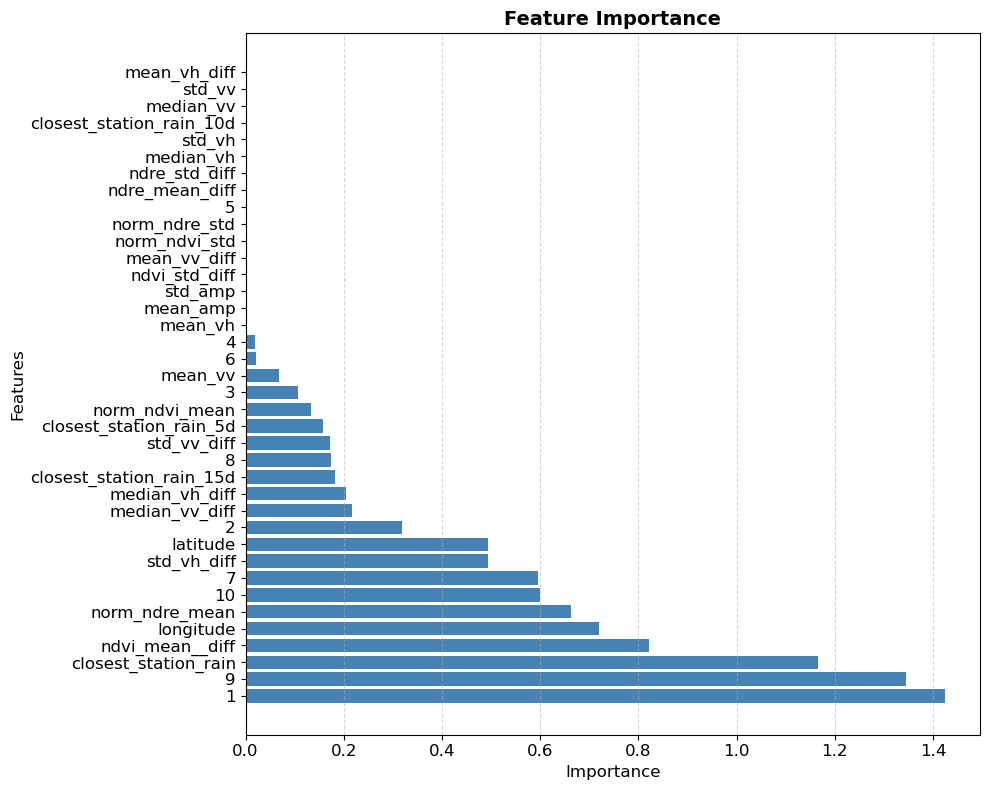

In [73]:
coefficients = model_tun3.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train3.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Confusion Matrix:
[[ 9  1]
 [ 2 10]]


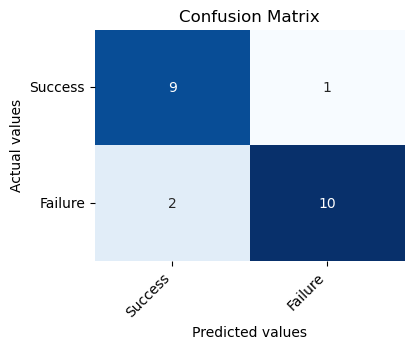

In [74]:
cm3 = confusion_matrix(y_test3, y_test_pred_lr3)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm3)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

## StageV4

In [75]:
df_v4_get_501=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\df_v4_get_incase.csv')
df_v4_get_502=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\Protocol_502\df_v4_get_incase_502.csv')

In [76]:
df_model_v4_501=df_v4_get_501[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

df_model_v4_502=df_v4_get_502[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv',
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '7', '8', '9', '10', '11','Identify']]

In [77]:
df_model_v4_501=df_model_v4_501[df_model_v4_501.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v4_501['norm_ndvi_mean'] = scaler.fit_transform(df_model_v4_501[['ndvi_mean']])
df_model_v4_501['norm_ndvi_std'] = scaler.fit_transform(df_model_v4_501[['ndvi_std']].values)
df_model_v4_501['norm_ndre_mean'] = scaler.fit_transform(df_model_v4_501[['ndre_mean']].values)
df_model_v4_501['norm_ndre_std'] = scaler.fit_transform(df_model_v4_501[['ndre_std']].values)

df_model_v4_501['ndvi_mean__diff'] = df_model_v4_501.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v4_501['ndvi_std_diff'] = df_model_v4_501.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v4_501['ndre_mean_diff'] = df_model_v4_501.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v4_501['ndre_std_diff'] = df_model_v4_501.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [78]:
df_model_v4_502=df_model_v4_502[df_model_v4_502.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v4_502['norm_ndvi_mean'] = scaler.fit_transform(df_model_v4_502[['ndvi_mean']])
df_model_v4_502['norm_ndvi_std'] = scaler.fit_transform(df_model_v4_502[['ndvi_std']].values)
df_model_v4_502['norm_ndre_mean'] = scaler.fit_transform(df_model_v4_502[['ndre_mean']].values)
df_model_v4_502['norm_ndre_std'] = scaler.fit_transform(df_model_v4_502[['ndre_std']].values)

df_model_v4_502['ndvi_mean__diff'] = df_model_v4_502.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v4_502['ndvi_std_diff'] = df_model_v4_502.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v4_502['ndre_mean_diff'] = df_model_v4_502.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v4_502['ndre_std_diff'] = df_model_v4_502.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [79]:
df_model_v4_501.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,6,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US501-IA01-5FELDM,41.864641,266.375284,0.610772,0.066255,0.488892,0.06648,-22.523012,-22.375841,2.163079,...,0.0,0,0.888033,0.111296,0.856456,0.122528,0.0,0.0,0.0,0.0


In [80]:
df_model_v4_502.columns

Index(['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '7', '8',
       '9', '10', '11', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff'],
      dtype='object')

In [81]:
df_model_v4_502.columns=['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '3', '7',
       '8', '9', '10', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff']

df_model_v4_502.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,10,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US502-IA01-5HEIMS,42.624221,268.519802,0.461452,0.01107,0.368161,0.011546,-19.944132,-19.620701,1.267582,...,0.0,0,0.626154,0.206051,0.609976,0.216303,0.0,0.0,0.0,0.0


In [82]:
df_model_v4_501=df_model_v4_501.dropna()
df_model_v4_502=df_model_v4_502.dropna()

print("501 shape:",df_model_v4_501.shape)
print("502 shape:",df_model_v4_502.shape)

501 shape: (92, 40)
502 shape: (44, 40)


In [183]:
39/64

0.609375

In [184]:
25/63

0.3968253968253968

In [83]:
df_model_v4=pd.concat([df_model_v4_501,df_model_v4_502], ignore_index=True)
df_model_v4.fillna(0, inplace=True)

StageV4 501 Successfull application 48
StageV4 501 Failure 44
StageV4 502 Successfull application 25
StageV4 502 Failure 19
StageV4 All Successfull application 73
StageV4 All Failure 63


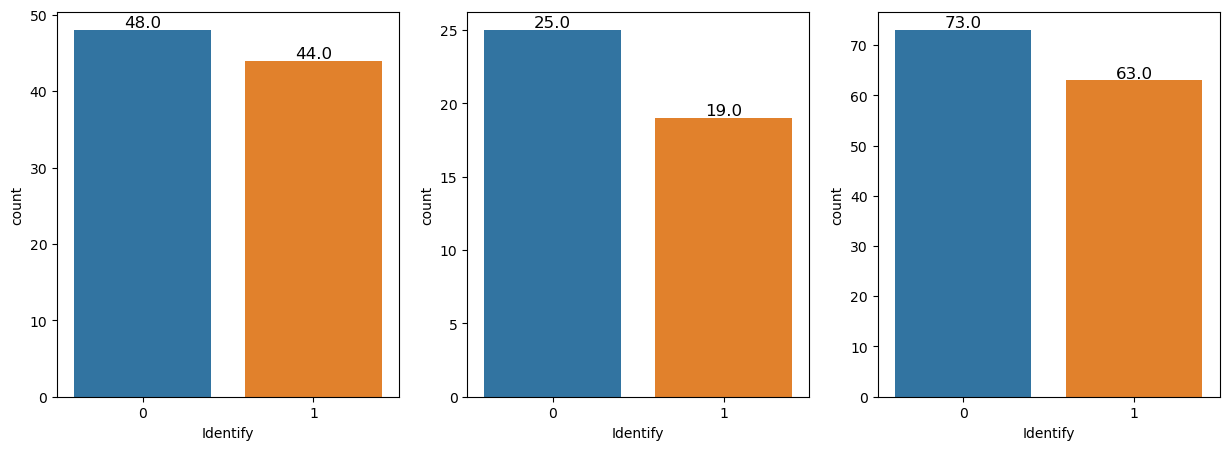

In [84]:
print("StageV4 501 Successfull application",df_model_v4_501[df_model_v4_501.Identify==0].Identify.count())
print("StageV4 501 Failure",df_model_v4_501[df_model_v4_501.Identify==1].Identify.count())

print("StageV4 502 Successfull application",df_model_v4_502[df_model_v4_502.Identify==0].Identify.count())
print("StageV4 502 Failure",df_model_v4_502[df_model_v4_502.Identify==1].Identify.count())

print("StageV4 All Successfull application",df_model_v4[df_model_v4.Identify==0].Identify.count())
print("StageV4 All Failure",df_model_v4[df_model_v4.Identify==1].Identify.count())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ax1=sns.countplot(data=df_model_v4_501, x='Identify')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
#
plt.subplot(1, 3, 2)
ax2=sns.countplot(data=df_model_v4_502, x='Identify')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.subplot(1, 3, 3)
ax3=sns.countplot(data=df_model_v4, x='Identify')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Train in 501 Test 501

In [85]:
part1=df_model_v4.iloc[0:92,:]

In [86]:
train_raw1, test_raw1 = train_test_split(part1,test_size=0.2, random_state=0)

In [87]:
X_train1 = train_raw1[features]
y_train1 = train_raw1[target]

X_test1 = test_raw1[features]
y_test1 = test_raw1[target]

In [88]:
model_names.append('LR_v4_501train_501test')

In [89]:
#### with amp
steps1 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model1 = Pipeline(steps1)

params1 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun1 = GridSearchCV(estimator = model1, param_grid = params1, scoring = scorer, cv = 5,error_score="raise")

model_tun1 = model_tun1.fit(X_train1, y_train1)

print('The best parameters finally chose are',model_tun1.best_params_)
print('The ROC_AUC score from these parameters is',model_tun1.best_score_)

pr_aucs3.append(model_tun1.best_score_)

y_train_pred_lr1=model_tun1.best_estimator_.predict(X_train1)
y_train_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_train1)

y_test_pred_lr1=model_tun1.best_estimator_.predict(X_test1)
y_test_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_test1)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(3,y_train1,y_train_pred_lr1,y_train_proba_lr1)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(3,y_test1,y_test_pred_lr1,y_test_proba_lr1)

The best parameters finally chose are {'lr__C': 1, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.6867460317460317
-------------------------Train dataset Result------------------------------
LR_v4_501train_501test Accuracy score is 0.8767123287671232
LR_v4_501train_501test Precision score is 0.8611111111111112
LR_v4_501train_501test Recall score is 0.8857142857142857
LR_v4_501train_501test F1 score is 0.8732394366197184
LR_v4_501train_501test ROC-AUC score is 0.9466165413533835
LR_v4_501train_501test PR-AUC score is 0.9522330306647827
-------------------------Test dataset Result------------------------------
LR_v4_501train_501test Accuracy score is 0.5263157894736842
LR_v4_501train_501test Precision score is 0.5
LR_v4_501train_501test Recall score is 0.5555555555555556
LR_v4_501train_501test F1 score is 0.5263157894736842
LR_v4_501train_501test ROC-AUC score is 0.6888888888888889
LR_v4_501train_501test PR-AUC score is 0.6870509120509121


Confusion Matrix:
[[5 5]
 [4 5]]


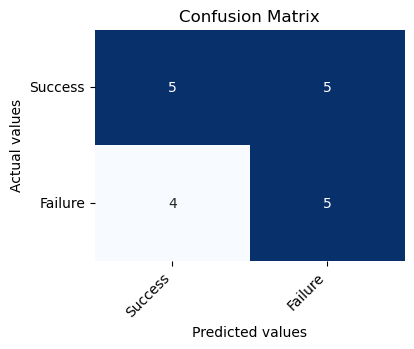

In [90]:
cm1 = confusion_matrix(y_test1, y_test_pred_lr1)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm1)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

### Train 501 Test in 502

In [91]:
model_names.append('LR_v4_501train_502test')

In [92]:
part2=df_model_v4.iloc[92:,:]
print(part2.shape)

(44, 44)


In [93]:
X_test2 = part2[features]
y_test2 = part2[target]

In [94]:
pr_aucs3.append(model_tun1.best_score_)

In [95]:
print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(4,y_train1,y_train_pred_lr1,y_train_proba_lr1)

-------------------------Train dataset Result------------------------------
LR_v4_501train_502test Accuracy score is 0.8767123287671232
LR_v4_501train_502test Precision score is 0.8611111111111112
LR_v4_501train_502test Recall score is 0.8857142857142857
LR_v4_501train_502test F1 score is 0.8732394366197184
LR_v4_501train_502test ROC-AUC score is 0.9466165413533835
LR_v4_501train_502test PR-AUC score is 0.9522330306647827


In [96]:
y_test_pred_lr2=model_tun1.best_estimator_.predict(X_test2)
y_test_proba_lr2 = model_tun1.best_estimator_.predict_proba(X_test2)

print("-------------------------Test dataset2 Result------------------------------")
add_print_metrics2(4,y_test2,y_test_pred_lr2,y_test_proba_lr2)

-------------------------Test dataset2 Result------------------------------
LR_v4_501train_502test Accuracy score is 0.4090909090909091
LR_v4_501train_502test Precision score is 0.3939393939393939
LR_v4_501train_502test Recall score is 0.6842105263157895
LR_v4_501train_502test F1 score is 0.5
LR_v4_501train_502test ROC-AUC score is 0.41263157894736835
LR_v4_501train_502test PR-AUC score is 0.41569775414503096


### Combination of 501 and 502

In [159]:
train_raw3, test_raw3 = train_test_split(df_model_v4,test_size=0.2, random_state=0)

In [160]:
X_train3 = train_raw3[features]
y_train3 = train_raw3[target]

X_test3 = test_raw3[features]
y_test3 = test_raw3[target]

In [99]:
model_names.append('LR_v4_501502train&test')

In [161]:
#### 
steps3 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model3 = Pipeline(steps3)

params3 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun3 = GridSearchCV(estimator = model3, param_grid = params3, scoring = scorer, cv = 5,error_score="raise")

model_tun3 = model_tun3.fit(X_train3, y_train3)

print('The best parameters finally chose are',model_tun3.best_params_)
print('The ROC_AUC score from these parameters is',model_tun3.best_score_)

pr_aucs3.append(model_tun3.best_score_)

y_train_pred_lr3=model_tun3.best_estimator_.predict(X_train3)
y_train_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_train3)

y_test_pred_lr3=model_tun3.best_estimator_.predict(X_test3)
y_test_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_test3)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(5,y_train3,y_train_pred_lr3,y_train_proba_lr3)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(5,y_test3,y_test_pred_lr3,y_test_proba_lr3)

The best parameters finally chose are {'lr__C': 100, 'lr__penalty': 'l1'}
The ROC_AUC score from these parameters is 0.5587243867243867
-------------------------Train dataset Result------------------------------
LR_v4_501502train&test Accuracy score is 0.8796296296296297
LR_v4_501502train&test Precision score is 0.8627450980392157
LR_v4_501502train&test Recall score is 0.88
LR_v4_501502train&test F1 score is 0.8712871287128714
LR_v4_501502train&test ROC-AUC score is 0.9231034482758621
LR_v4_501502train&test PR-AUC score is 0.9086168862250801
-------------------------Test dataset Result------------------------------
LR_v4_501502train&test Accuracy score is 0.75
LR_v4_501502train&test Precision score is 0.7142857142857143
LR_v4_501502train&test Recall score is 0.7692307692307693
LR_v4_501502train&test F1 score is 0.7407407407407408
LR_v4_501502train&test ROC-AUC score is 0.7846153846153846
LR_v4_501502train&test PR-AUC score is 0.738203646092688


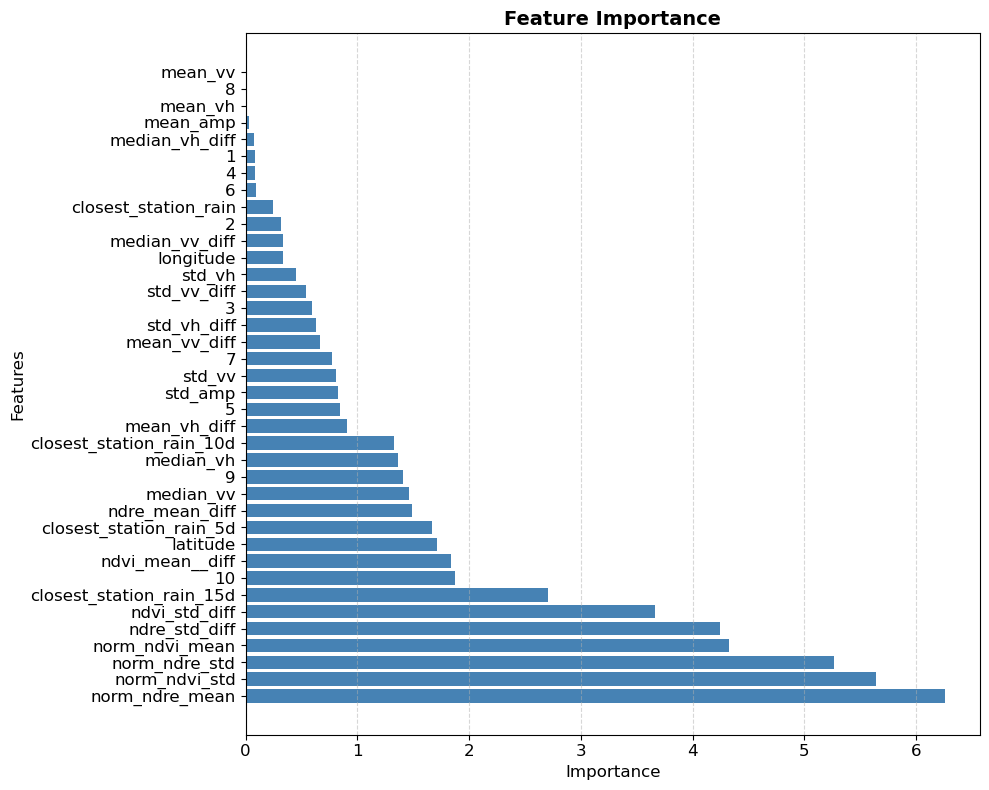

In [101]:
coefficients = model_tun3.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train3.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Confusion Matrix:
[[11  4]
 [ 3 10]]


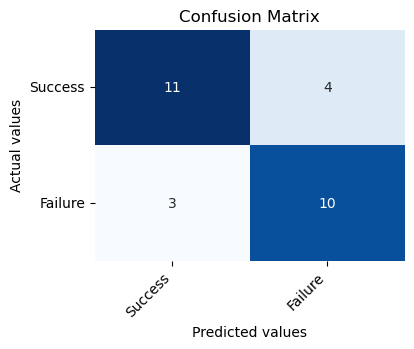

In [102]:
cm3 = confusion_matrix(y_test3, y_test_pred_lr3)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm3)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

### make up test

In [162]:
add_test1=X_test3.copy()
add_test1['Identify']=y_test3

In [163]:
X_test33=add_test1[add_test1.Identify==1].iloc[:,:-1]
y_test33=add_test1[add_test1.Identify==1].Identify

In [150]:
model_names.append('LR_v4_501502train&test_only1s')

In [166]:
y_test_pred_lr33=model_tun3.best_estimator_.predict(X_test33)
y_test_proba_lr33 = model_tun3.best_estimator_.predict_proba(X_test33)

print("-------------------------Test dataset Result------------------------------")
model_idx=9
print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} Precision score is {precision_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} Recall score is {recall_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} F1 score is {f1_score(y_test33,y_test_pred_lr33)}")

print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y_test33,y_test_proba_lr33[:,1])}")

-------------------------Test dataset Result------------------------------
LR_v4_501502train&test_only1s Accuracy score is 0.7692307692307693
LR_v4_501502train&test_only1s Precision score is 1.0
LR_v4_501502train&test_only1s Recall score is 0.7692307692307693
LR_v4_501502train&test_only1s F1 score is 0.8695652173913044
LR_v4_501502train&test_only1s PR-AUC score is 0.9999999999999998


In [170]:
comparison=pd.DataFrame(y_test33)
comparison['model']=y_test_pred_lr33

comparison['ComparisonResult'] = comparison.apply(lambda row: 1 if row['Identify'] == row['model'] else 0, axis=1)

# Calculate percentage of equal ones
percentage_equal = (comparison['ComparisonResult'].mean()) * 100

print("Percentage of equal ones:", percentage_equal)

Percentage of equal ones: 76.92307692307693


## StageV6

In [103]:
df_v6_get_501=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\df_v6_get_incase.csv')
df_v6_get_502=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\Protocol_502\df_v6_get_incase_502.csv')

In [104]:
df_model_v6_501=df_v6_get_501[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

df_model_v6_502=df_v6_get_502[['trial_id','latitude', 'longitude',
       'ndvi_mean', 'ndvi_std', 'ndre_mean','ndre_std',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv',
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '7', '8', '9', '10', '11','Identify']]

In [105]:
df_model_v6_501=df_model_v6_501[df_model_v6_501.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v6_501['norm_ndvi_mean'] = scaler.fit_transform(df_model_v6_501[['ndvi_mean']])
df_model_v6_501['norm_ndvi_std'] = scaler.fit_transform(df_model_v6_501[['ndvi_std']].values)
df_model_v6_501['norm_ndre_mean'] = scaler.fit_transform(df_model_v6_501[['ndre_mean']].values)
df_model_v6_501['norm_ndre_std'] = scaler.fit_transform(df_model_v6_501[['ndre_std']].values)

df_model_v6_501['ndvi_mean__diff'] = df_model_v6_501.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v6_501['ndvi_std_diff'] = df_model_v6_501.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v6_501['ndre_mean_diff'] = df_model_v6_501.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v6_501['ndre_std_diff'] = df_model_v6_501.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [106]:
df_model_v6_502=df_model_v6_502[df_model_v6_502.ndvi_mean>0]

scaler = MinMaxScaler()
df_model_v6_502['norm_ndvi_mean'] = scaler.fit_transform(df_model_v6_502[['ndvi_mean']])
df_model_v6_502['norm_ndvi_std'] = scaler.fit_transform(df_model_v6_502[['ndvi_std']].values)
df_model_v6_502['norm_ndre_mean'] = scaler.fit_transform(df_model_v6_502[['ndre_mean']].values)
df_model_v6_502['norm_ndre_std'] = scaler.fit_transform(df_model_v6_502[['ndre_std']].values)

df_model_v6_502['ndvi_mean__diff'] = df_model_v6_502.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_model_v6_502['ndvi_std_diff'] = df_model_v6_502.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_model_v6_502['ndre_mean_diff'] = df_model_v6_502.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_model_v6_502['ndre_std_diff'] = df_model_v6_502.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [107]:
df_model_v6_501.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,6,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US501-IA01-5FELDM,41.864641,266.375284,0.779997,0.063422,0.656178,0.070593,-22.523006,-22.375801,2.163071,...,0.0,0,0.904981,0.070922,0.837181,0.113735,0.0,0.0,0.0,0.0


In [108]:
df_model_v6_502.columns

Index(['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '7', '8',
       '9', '10', '11', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff'],
      dtype='object')

In [109]:
df_model_v6_502.columns=['trial_id', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_std',
       'ndre_mean', 'ndre_std', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '3', '7',
       '8', '9', '10', 'Identify', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff']

df_model_v3_502.head(1)

,trial_id,latitude,longitude,ndvi_mean,ndvi_std,ndre_mean,ndre_std,mean_vh,median_vh,std_vh,...,10,Identify,norm_ndvi_mean,norm_ndvi_std,norm_ndre_mean,norm_ndre_std,ndvi_mean__diff,ndvi_std_diff,ndre_mean_diff,ndre_std_diff
0,22-ZEAMX-US502-IA01-5HEIMS,42.624221,268.519802,0.383388,0.010286,0.30543,0.012132,-20.057127,-20.063561,1.805224,...,0.0,0,0.423537,0.203573,0.364664,0.37162,0.0,0.0,0.0,0.0


In [110]:
df_model_v6_501=df_model_v6_501.dropna()
df_model_v6_502=df_model_v6_502.dropna()

print("501 shape:",df_model_v6_501.shape)
print("502 shape:",df_model_v6_502.shape)

501 shape: (94, 40)
502 shape: (56, 40)


In [111]:
df_model_v6=pd.concat([df_model_v6_501,df_model_v6_502], ignore_index=True)
df_model_v6.fillna(0, inplace=True)

StageV6 501 Successfull application 55
StageV6 501 Failure 39
StageV6 502 Successfull application 31
StageV6 502 Failure 25
StageV6 All Successfull application 86
StageV6 All Failure 64


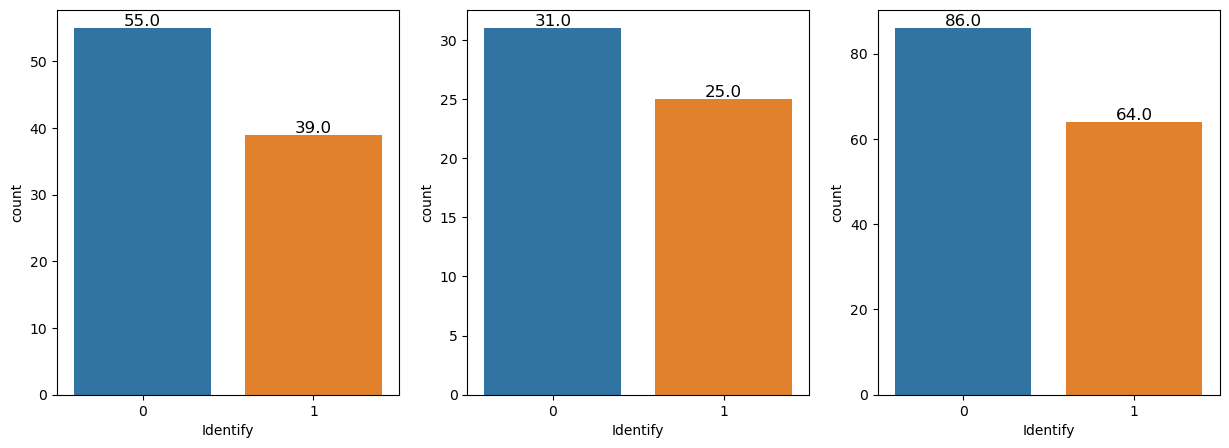

In [112]:
print("StageV6 501 Successfull application",df_model_v6_501[df_model_v6_501.Identify==0].Identify.count())
print("StageV6 501 Failure",df_model_v6_501[df_model_v6_501.Identify==1].Identify.count())

print("StageV6 502 Successfull application",df_model_v6_502[df_model_v6_502.Identify==0].Identify.count())
print("StageV6 502 Failure",df_model_v6_502[df_model_v6_502.Identify==1].Identify.count())

print("StageV6 All Successfull application",df_model_v6[df_model_v6.Identify==0].Identify.count())
print("StageV6 All Failure",df_model_v6[df_model_v6.Identify==1].Identify.count())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ax1=sns.countplot(data=df_model_v6_501, x='Identify')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
#
plt.subplot(1, 3, 2)
ax2=sns.countplot(data=df_model_v6_502, x='Identify')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.subplot(1, 3, 3)
ax3=sns.countplot(data=df_model_v6, x='Identify')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Train in 501 Test 501

In [113]:
part1=df_model_v6.iloc[0:94,:]

In [114]:
train_raw1, test_raw1 = train_test_split(part1,test_size=0.2, random_state=0)

In [115]:
X_train1 = train_raw1[features]
y_train1 = train_raw1[target]

X_test1 = test_raw1[features]
y_test1 = test_raw1[target]

In [116]:
model_names.append('LR_v6_501train_501test')

In [117]:
#### with amp
steps1 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model1 = Pipeline(steps1)

params1 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun1 = GridSearchCV(estimator = model1, param_grid = params1, scoring = scorer, cv = 5,error_score="raise")

model_tun1 = model_tun1.fit(X_train1, y_train1)

print('The best parameters finally chose are',model_tun1.best_params_)
print('The ROC_AUC score from these parameters is',model_tun1.best_score_)

pr_aucs3.append(model_tun1.best_score_)

y_train_pred_lr1=model_tun1.best_estimator_.predict(X_train1)
y_train_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_train1)

y_test_pred_lr1=model_tun1.best_estimator_.predict(X_test1)
y_test_proba_lr1 = model_tun1.best_estimator_.predict_proba(X_test1)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(6,y_train1,y_train_pred_lr1,y_train_proba_lr1)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(6,y_test1,y_test_pred_lr1,y_test_proba_lr1)

The best parameters finally chose are {'lr__C': 1, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.545095238095238
-------------------------Train dataset Result------------------------------
LR_v6_501train_501test Accuracy score is 0.8133333333333334
LR_v6_501train_501test Precision score is 0.7096774193548387
LR_v6_501train_501test Recall score is 0.8148148148148148
LR_v6_501train_501test F1 score is 0.7586206896551724
LR_v6_501train_501test ROC-AUC score is 0.912037037037037
LR_v6_501train_501test PR-AUC score is 0.8690476501489734
-------------------------Test dataset Result------------------------------
LR_v6_501train_501test Accuracy score is 0.7894736842105263
LR_v6_501train_501test Precision score is 1.0
LR_v6_501train_501test Recall score is 0.6666666666666666
LR_v6_501train_501test F1 score is 0.8
LR_v6_501train_501test ROC-AUC score is 0.8095238095238095
LR_v6_501train_501test PR-AUC score is 0.9093844268476622


Confusion Matrix:
[[7 0]
 [4 8]]


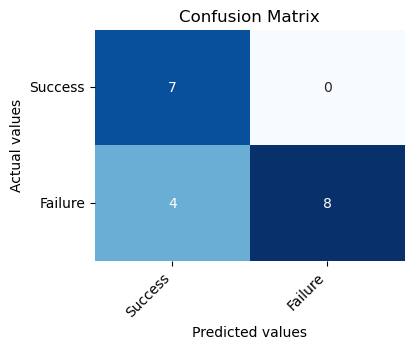

In [118]:
cm1 = confusion_matrix(y_test1, y_test_pred_lr1)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm1)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

### Train 501 Test in 502

In [119]:
model_names.append('LR_v6_501train_502test')

In [120]:
part2=df_model_v4.iloc[94:,:]
print(part2.shape)

(42, 44)


In [121]:
X_test2 = part2[features]
y_test2 = part2[target]

In [122]:
pr_aucs3.append(model_tun1.best_score_)

In [123]:
print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(7,y_train1,y_train_pred_lr1,y_train_proba_lr1)

-------------------------Train dataset Result------------------------------
LR_v6_501train_502test Accuracy score is 0.8133333333333334
LR_v6_501train_502test Precision score is 0.7096774193548387
LR_v6_501train_502test Recall score is 0.8148148148148148
LR_v6_501train_502test F1 score is 0.7586206896551724
LR_v6_501train_502test ROC-AUC score is 0.912037037037037
LR_v6_501train_502test PR-AUC score is 0.8690476501489734


In [124]:
y_test_pred_lr2=model_tun1.best_estimator_.predict(X_test2)
y_test_proba_lr2 = model_tun1.best_estimator_.predict_proba(X_test2)

print("-------------------------Test dataset2 Result------------------------------")
add_print_metrics2(7,y_test2,y_test_pred_lr2,y_test_proba_lr2)

-------------------------Test dataset2 Result------------------------------
LR_v6_501train_502test Accuracy score is 0.4523809523809524
LR_v6_501train_502test Precision score is 0.4166666666666667
LR_v6_501train_502test Recall score is 0.5263157894736842
LR_v6_501train_502test F1 score is 0.46511627906976744
LR_v6_501train_502test ROC-AUC score is 0.4897025171624714
LR_v6_501train_502test PR-AUC score is 0.4542790212267147


### Combination of 501 and 502

In [171]:
train_raw3, test_raw3 = train_test_split(df_model_v6,test_size=0.2, random_state=0)

In [172]:
X_train3 = train_raw3[features]
y_train3 = train_raw3[target]

X_test3 = test_raw3[features]
y_test3 = test_raw3[target]

In [127]:
model_names.append('LR_v6_501502train&test')

In [173]:
#### 
steps3 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model3 = Pipeline(steps3)

params3 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun3 = GridSearchCV(estimator = model3, param_grid = params3, scoring = scorer, cv = 5,error_score="raise")

model_tun3 = model_tun3.fit(X_train3, y_train3)

print('The best parameters finally chose are',model_tun3.best_params_)
print('The ROC_AUC score from these parameters is',model_tun3.best_score_)

pr_aucs3.append(model_tun3.best_score_)

y_train_pred_lr3=model_tun3.best_estimator_.predict(X_train3)
y_train_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_train3)

y_test_pred_lr3=model_tun3.best_estimator_.predict(X_test3)
y_test_proba_lr3 = model_tun3.best_estimator_.predict_proba(X_test3)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(8,y_train3,y_train_pred_lr3,y_train_proba_lr3)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(8,y_test3,y_test_pred_lr3,y_test_proba_lr3)

The best parameters finally chose are {'lr__C': 10, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.6186363636363637
-------------------------Train dataset Result------------------------------
LR_v6_501502train&test Accuracy score is 0.8416666666666667
LR_v6_501502train&test Precision score is 0.8113207547169812
LR_v6_501502train&test Recall score is 0.8269230769230769
LR_v6_501502train&test F1 score is 0.819047619047619
LR_v6_501502train&test ROC-AUC score is 0.9216628959276018
LR_v6_501502train&test PR-AUC score is 0.8970354215641037
-------------------------Test dataset Result------------------------------
LR_v6_501502train&test Accuracy score is 0.7333333333333333
LR_v6_501502train&test Precision score is 0.6428571428571429
LR_v6_501502train&test Recall score is 0.75
LR_v6_501502train&test F1 score is 0.6923076923076924
LR_v6_501502train&test ROC-AUC score is 0.8240740740740741
LR_v6_501502train&test PR-AUC score is 0.7994829877724615


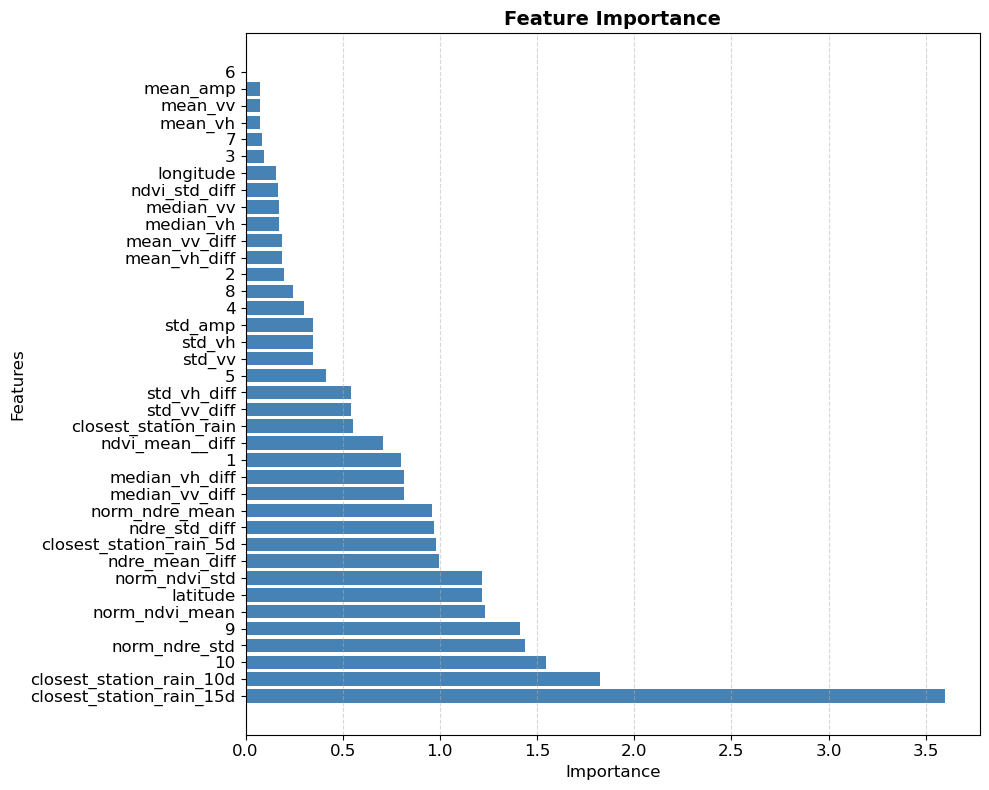

In [129]:
coefficients = model_tun3.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train3.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Confusion Matrix:
[[13  5]
 [ 3  9]]


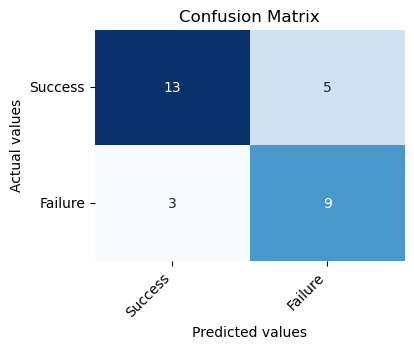

In [130]:
cm3 = confusion_matrix(y_test3, y_test_pred_lr3)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm3)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

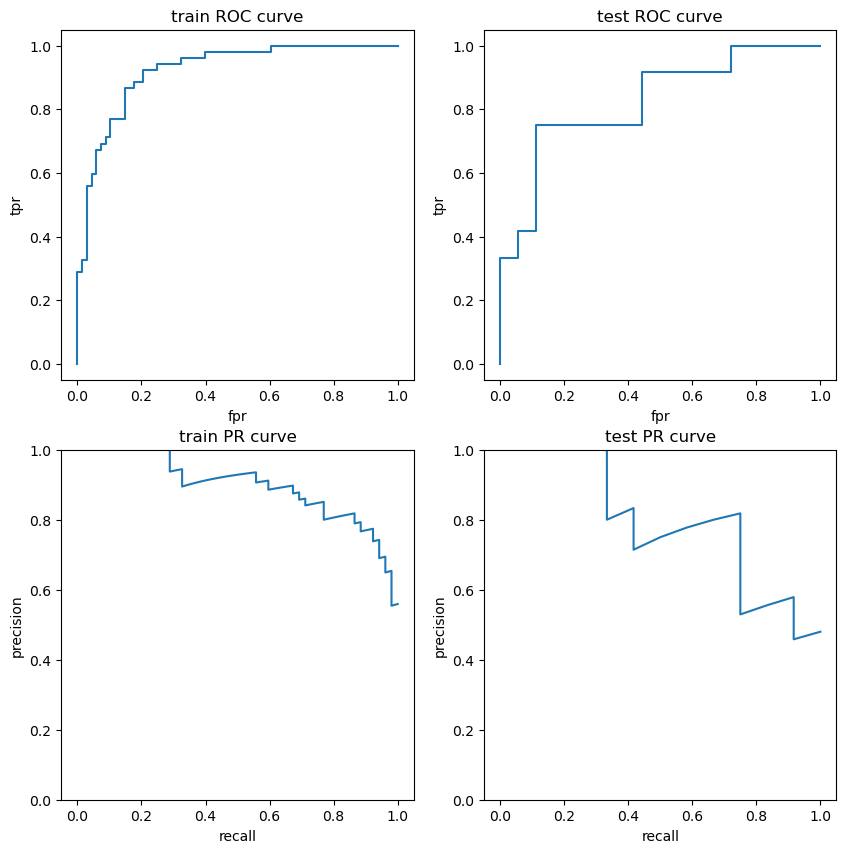

In [131]:
# train_raw3, test_raw3 = train_test_split(df_model_v6,test_size=0.2, random_state=0)
# plot ROC curve and PR curve

fpr, tpr, th = roc_curve(y_train3, y_train_proba_lr3[:, 1])
fpr1, tpr1, th1 = roc_curve(y_test3, y_test_proba_lr3[:, 1])

precision, recall, threshold = precision_recall_curve(y_train3, y_train_proba_lr3[:,1])
precision1, recall1, threshold1 = precision_recall_curve(y_test3, y_test_proba_lr3[:,1])

fig, axe = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)

axe[0, 0].plot(fpr, tpr)
axe[0, 0].set_xlabel('fpr')
axe[0, 0].set_ylabel('tpr')
axe[0, 0].set_title('train ROC curve')

axe[0, 1].plot(fpr1, tpr1)
axe[0, 1].set_xlabel('fpr')
axe[0, 1].set_ylabel('tpr')
axe[0, 1].set_title('test ROC curve')

axe[1, 0].plot(recall, precision)
axe[1, 0].set_xlabel('recall')
axe[1, 0].set_ylabel('precision')
axe[1, 0].set_title('train PR curve')
axe[1, 0].set_ylim(0, 1)


axe[1, 1].plot(recall1, precision1)
axe[1, 1].set_xlabel('recall')
axe[1, 1].set_ylabel('precision')
axe[1, 1].set_title('test PR curve')
axe[1, 1].set_ylim(0, 1)


plt.show()

### make up test

In [174]:
add_test2=X_test3.copy()
add_test2['Identify']=y_test3

In [176]:
X_test33=add_test2[add_test2.Identify==1].iloc[:,:-1]
y_test33=add_test2[add_test2.Identify==1].Identify

In [177]:
model_names.append('LR_v6_501502train&test_only1s')

In [178]:
y_test_pred_lr33=model_tun3.best_estimator_.predict(X_test33)
y_test_proba_lr33 = model_tun3.best_estimator_.predict_proba(X_test33)

print("-------------------------Test dataset Result------------------------------")
model_idx=10
print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} Precision score is {precision_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} Recall score is {recall_score(y_test33,y_test_pred_lr33)}")
print(f"{model_names[model_idx]} F1 score is {f1_score(y_test33,y_test_pred_lr33)}")

print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y_test33,y_test_proba_lr33[:,1])}")

-------------------------Test dataset Result------------------------------
LR_v6_501502train&test_only1s Accuracy score is 0.75
LR_v6_501502train&test_only1s Precision score is 1.0
LR_v6_501502train&test_only1s Recall score is 0.75
LR_v6_501502train&test_only1s F1 score is 0.8571428571428571
LR_v6_501502train&test_only1s PR-AUC score is 1.0


In [179]:
comparison2=pd.DataFrame(y_test33)
comparison2['model']=y_test_pred_lr33

comparison2['ComparisonResult'] = comparison2.apply(lambda row: 1 if row['Identify'] == row['model'] else 0, axis=1)

# Calculate percentage of equal ones
percentage_equal2 = (comparison2['ComparisonResult'].mean()) * 100

print("Percentage of equal ones:", percentage_equal2)

Percentage of equal ones: 75.0


# Comparison

In [132]:
data = {"model": model_names,
        "train_accuracy": accuracys1,
        "test_accuracy": accuracys2,
        "train_precision": precisions1,
        "test_precision": precisions2,
        "train_recall": recalls1,
        "test_recall": recalls2,
        "train_F1": f1s1,
        "test_F1": f1s2,
        "train_ROC_AUC": roc_aucs1,
        "test_ROC_AUC": roc_aucs2,
        "train_PR_AUC": pr_aucs1,
        "test_PR_AUC": pr_aucs2,
        "validation_PR_AUC":pr_aucs3
       }

In [133]:
performance=pd.DataFrame(data)
performance

,model,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_F1,test_F1,train_ROC_AUC,test_ROC_AUC,train_PR_AUC,test_PR_AUC,validation_PR_AUC
0,LR_v3_501train_501test,0.884615,0.571429,0.761905,0.750000,0.941176,0.375000,0.842105,0.500000,0.981513,0.625000,0.967946,0.770766,0.672197
1,LR_v3_501train_502test,0.884615,0.613636,0.761905,0.750000,0.941176,0.480000,0.842105,0.585366,0.981513,0.637895,0.967946,0.695111,0.672197
2,LR_v3_501502train&test,0.909091,0.863636,0.857143,0.909091,0.947368,0.833333,0.900000,0.869565,0.957368,0.966667,0.948291,0.970736,0.648072
3,LR_v4_501train_501test,0.876712,0.526316,0.861111,0.500000,0.885714,0.555556,0.873239,0.526316,0.946617,0.688889,0.952233,0.687051,0.686746
4,LR_v4_501train_502test,0.876712,0.409091,0.861111,0.393939,0.885714,0.684211,0.873239,0.500000,0.946617,0.412632,0.952233,0.415698,0.686746
5,LR_v4_501502train&test,0.879630,0.750000,0.862745,0.714286,0.880000,0.769231,0.871287,0.740741,0.923103,0.784615,0.908617,0.738204,0.558724
6,LR_v6_501train_501test,0.813333,0.789474,0.709677,1.000000,0.814815,0.666667,0.758621,0.800000,0.912037,0.809524,0.869048,0.909384,0.545095
7,LR_v6_501train_502test,0.813333,0.452381,0.709677,0.416667,0.814815,0.526316,0.758621,0.465116,0.912037,0.489703,0.869048,0.454279,0.545095
8,LR_v6_501502train&test,0.841667,0.733333,0.811321,0.642857,0.826923,0.750000,0.819048,0.692308,0.921663,0.824074,0.897035,0.799483,0.618636


In [180]:
to_get=performance[['model','train_precision','test_precision', 'train_recall', 'test_recall', 'train_F1', 'test_F1', 'train_PR_AUC', 'test_PR_AUC']].round(2)
to_get.to_csv('performance_comparison501_502_revise.csv',index=None)